In [1]:
import numpy as np
import pandas as pd
import random 

from scipy.stats import pearsonr
import itertools

In [2]:
#Define function for obtaining protein-level abundances

def mapPeptidestoProteins(peptide_df):
    
    #Map to proteins using mean across all peptides
    print("Mapping to protein-level using top peptide with highest R2 score")
    new_df_list = []
    all_proteins = np.unique(peptide_df['Protein'].values)

    #Map to proteins by taking the peptide with top R2
    for p in all_proteins:
        #print(p)

        sub_df = peptide_df[peptide_df['Protein'] == p]
        #print(sub_df.shape)
        #print(sub_df)

        top_index = np.argsort(sub_df['R2'].values)[-1]
        new_df = pd.DataFrame(sub_df.iloc[top_index, 12:].values, 
                              index = sub_df.columns[12:], columns = [sub_df['gene symbol'].iloc[top_index]])
        #print(new_df)
        new_df_list.append(new_df)

    peptide_df = pd.concat(new_df_list, axis = 1).T
    print(peptide_df)
    
    #Calculate the average expression of duplicate samples
    print("Calculating mean abundance across duplicate samples")
    all_dfs = []
    i = 0
    while i < peptide_df.shape[1]:
        values1 = peptide_df.iloc[:, i].values
        values2 = peptide_df.iloc[:, i+1].values
        avg_values = (values1 + values2) / 2
        new_df = pd.DataFrame(avg_values, index = peptide_df.index, columns = [peptide_df.columns[i][:-2]])
        all_dfs.append(new_df)
        i = i + 2
    protein_df = pd.concat(all_dfs, axis = 1)
    
    #Rename samples
    sample_names = protein_df.columns
    sample_names = [i.replace(':', '').replace('_', '').replace(' ', '') for i in sample_names]
    protein_df = pd.DataFrame(protein_df.values, index = protein_df.index, 
                           columns = sample_names)
    print(protein_df)

    return protein_df



In [3]:
#Define function for calculating protein complex correlations

def calculateProteinandGeneCorrelations(protein_df, gene_df):
    
    print("Protein df ", protein_df.shape)
    print("Gene df ", gene_df.shape)
    
    #Find common indices
    all_proteins = np.intersect1d(np.array(protein_df.index.values).astype(str), 
                              np.array(gene_df.index.values).astype(str))
    print("Number of common proteins ", len(all_proteins))
    
    protein_df = protein_df.loc[all_proteins]
    new_protein_list = []
    for gene in all_proteins:
        sub_df = protein_df[protein_df.index == gene]
        new_protein_list.append(sub_df.mean(axis = 0))
    protein_df = pd.concat(new_protein_list, axis = 1).T
    protein_df.index = all_proteins
    print(protein_df)
    
    gene_df = gene_df.loc[all_proteins]
    new_gene_list = []
    for gene in all_proteins:
        sub_df = gene_df[gene_df.index == gene]
        new_gene_list.append(sub_df.mean(axis = 0))
    gene_df = pd.concat(new_gene_list, axis = 1).T
    gene_df.index = all_proteins
    print(gene_df)
    
    all_correlations = []
    all_genes = []
    all_proteins = []
    common_samples = np.intersect1d(protein_df.columns, gene_df.columns)
    for sample in common_samples:
        print(sample)

        sub_gene = gene_df[sample].values
        sub_protein = np.log10(protein_df[sample].values + 1e-20)
       
        print(sub_gene)
        print(sub_protein)
        corr, pval =  pearsonr(sub_gene, sub_protein)
        all_correlations.append(corr)
        print(corr)
        print("-------")
        all_genes.append(sub_gene)
        all_proteins.append(sub_protein)
    
    return [all_correlations, all_genes, all_proteins]

In [4]:
#Read gene expression and rename samples
filename = '../../../data/2021-07-21/2021_guo_nci60/gene_expression/mRNA_expression.tsv'

gene_df = pd.read_csv(filename, sep = '\t')
gene_df = gene_df.dropna(how = 'all')
gene_df = gene_df.iloc[:, :-10]
sample_names = gene_df.columns
sample_names = [i.replace(':', '').replace('-', '').replace(' ', '') for i in sample_names]
sample_names[np.where(np.array(sample_names) == 'LCA549/ATCC')[0][0]] = 'LCA549'
sample_names[np.where(np.array(sample_names) == 'LEHL60(TB)')[0][0]] = 'LEHL60'
sample_names[np.where(np.array(sample_names) == 'OVNCI/ADRRES')[0][0]] = 'OVNCIADRRES'
gene_df = pd.DataFrame(gene_df.values, index = gene_df.index, 
                       columns = sample_names)
gene_df.index = gene_df['Genename']
gene_df = gene_df.iloc[:, 7:]
gene_df.values[gene_df.values == '-'] = np.nan
gene_df




/Users/berceste/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,BRMCF7,BRMDAMB231,BRHS578T,BRBT549,BRT47D,CNSSF268,CNSSF295,CNSSF539,CNSSNB19,CNSSNB75,...,PRPC3,PRDU145,RE7860,REA498,REACHN,RECAKI1,RERXF393,RESN12C,RETK10,REUO31
Genename,,,,,,,,,,,,,,,,,,,,,
RAB7B,2.286,2.286,2.286,2.972,2.286,2.286,2.328,2.684,2.286,4.632,...,2.286,2.286,2.286,2.286,2.301,2.36,2.326,2.286,2.286,2.436
LOC100996756,6.262,2.377,2.381,2.286,4.114,2.386,2.443,2.317,3.884,2.374,...,2.35,6.037,2.495,2.286,2.345,2.286,2.373,2.378,2.383,2.29
LOC100996740,2.984,8.166,6.702,3.03,8.655,8.622,8.476,7.424,7.715,6.156,...,6.92,9.093,6.921,7.316,6.539,7.623,8.007,3.774,8.386,8.215
RAB7B,2.287,2.287,2.343,4.001,2.288,2.287,2.322,3.272,2.343,5.396,...,2.287,2.316,2.287,2.483,2.369,2.581,2.51,2.29,2.637,4.007
-,8.505,8.079,8.907,8.07,8.526,7.817,7.962,8.044,8.073,8.087,...,8.575,8.272,8.263,7.482,8.114,7.874,8.022,8.334,8.22,8.048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KIR2DS1,2.286,2.286,2.286,2.286,2.286,2.286,2.286,2.286,2.286,2.286,...,2.286,2.286,2.286,2.286,2.286,2.286,2.286,2.286,2.286,2.286
KIR2DS1,2.343,2.302,2.286,2.286,2.286,2.286,2.317,2.287,2.286,2.456,...,2.292,2.286,2.286,2.293,2.31,2.286,2.286,2.317,2.286,2.287
MGC70870,6.762,6.542,5.794,6.395,6.532,6.432,6.268,6.322,6.644,5.683,...,6.338,9.453,6.603,6.65,6.844,6.667,6.462,6.556,6.472,6.637


## 1) Measure gene-protein correlations using the original peptide quants 

In [5]:
#Read protein expressions
peptide_df = pd.read_csv('../preprocess_datasets/preprocessed_datasets/2019_guo_nci60_formatted_peptide_quants.tsv',
                          sep = '\t', index_col = 0)
peptide_df.iloc[:, 12:]

,BR_BT549_a,BR_BT549_b,BR_HS578T_a,BR_HS578T_b,BR_MCF7_a,BR_MCF7_b,BR_MDAMB231_a,BR_MDAMB231_b,BR_MDAMB468_a,BR_MDAMB468_b,...,RE_CAKI1_a,RE_CAKI1_b,RE_RXF393_a,RE_RXF393_b,RE_SN12C_a,RE_SN12C_b,RE_TK10_a,RE_TK10_b,RE_UO31_a,RE_UO31_b
1,67736.6,49688.7,57732.7,63349.2,67598.8,61756.7,62153.9,64372.2,128863.4,141989.2,...,184888.7,157024.0,49126.2,52422.3,37285.8,38880.8,179390.0,148828.3,208464.9,183507.2
3,518728.7,533520.9,419320.4,396663.1,317684.0,366097.8,728045.2,703092.6,696036.0,692893.5,...,623419.3,676515.0,521146.7,505380.1,512520.5,588922.3,836327.0,855696.7,844485.0,958940.3
4,104188.8,92525.2,63399.3,58560.5,67032.1,54468.8,86685.3,77341.9,119237.3,111239.7,...,121129.1,111926.1,82168.3,79697.7,86637.4,86046.4,162744.6,140120.6,158263.5,147559.2
5,223566.3,215846.3,118357.8,122532.4,175728.4,164791.1,311832.8,305223.6,352443.2,316824.6,...,332466.8,303315.1,262901.7,219749.2,238151.9,240847.5,381630.9,323716.2,416258.4,358276.0
6,288719.4,234036.4,151627.7,128960.8,180224.5,167356.6,286434.0,319238.4,346288.3,316117.6,...,313338.2,307400.9,267945.1,253036.2,275804.3,244736.9,366880.1,350980.3,423942.9,372984.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22541,73385.3,77362.8,98136.2,94244.5,80880.9,57100.6,84179.0,85921.9,59872.7,72424.7,...,126396.9,115465.7,155045.8,150804.4,91421.7,114228.9,112403.4,117977.3,141709.4,143503.7
22543,6218.5,5104.3,13853.8,11655.2,1221.9,1970.2,7877.3,8134.6,3954.0,3474.4,...,9361.0,7864.9,15023.6,16419.2,8675.6,9419.2,8076.9,7327.0,14040.5,13399.5
22544,47392.5,56741.2,49882.2,58919.8,45155.2,34659.3,52234.9,51076.1,34167.3,27206.7,...,72928.2,60348.4,92661.4,76823.6,53861.6,70917.5,72388.0,67317.0,79469.1,86790.7
22545,248700.6,171957.9,310586.4,289012.3,287223.2,185662.4,310782.2,275944.1,167880.6,271876.2,...,233653.1,323083.7,497715.0,479244.1,274234.3,235873.7,332520.8,247520.0,379462.9,321573.3


In [6]:
protein_df = mapPeptidestoProteins(peptide_df)
protein_df

Mapping to protein-level using top peptide with highest R2 score
         BR_BT549_a BR_BT549_b BR_HS578T_a BR_HS578T_b BR_MCF7_a BR_MCF7_b  \
RBM47        245727     258864      368363      273571    425923    347506   
UBA6         336304     314985     47653.2     47653.2    378437    409848   
KIAA1598    25295.6    33184.4     4271.35     4271.35     75969   69072.3   
ILVBL         70080    71428.3     65681.1     63151.5   86408.3   88170.1   
CNOT1       80054.6      67736     51003.9       58915   92648.8   78550.6   
...             ...        ...         ...         ...       ...       ...   
DYNC1LI1    56654.4    38546.7       67984     65764.5   57762.2   53329.9   
IGF2BP2      4699.8     4699.8       43257     24653.2   21392.6   30993.2   
SLC30A1     2323.55    2323.55     2323.55     2323.55   17787.3   33369.2   
SLC4A7         3370       3370        3370        3370      3370      3370   
SQRDL        167407     171082      193354     98853.2    133980    153572   

,BRBT549,BRHS578T,BRMCF7,BRMDAMB231,BRMDAMB468,BRT47D,CNSSF268,CNSSF295,CNSSF539,CNSSNB19,...,PRDU145,PRPC3,RE7860,REA498,REACHN,RECAKI1,RERXF393,RESN12C,RETK10,REUO31
RBM47,252296,320967,386714,308863,291428,296138,161876,328065,259639,240479,...,231155,240415,260905,342500,376886,289172,306021,276935,378189,313858
UBA6,325644,47653.2,394142,47653.2,47653.2,188435,409606,275465,188715,47653.2,...,47653.2,313214,301022,196918,47653.2,378385,913480,333520,262600,268524
KIAA1598,29240,4271.35,72520.6,40391.6,46675.1,70061.1,20790.5,16165.6,4271.35,26431.7,...,59231.7,56965.2,48695.2,91642.5,45620.2,57368,58032.2,22622.1,56511.7,36624.6
ILVBL,70754.1,64416.3,87289.2,67683.1,56202.6,94685.5,69136.7,92784.1,84796.6,59800.6,...,55716.7,90523.3,53067,77795,79517.4,87116.9,52807.7,58983.2,71772.9,46540.4
CNOT1,73895.3,54959.4,85599.7,75935.9,84310,85241.7,66847.1,75168.6,71384.3,80808.6,...,82381.9,93076.8,79930.5,79205.8,81695.2,66447.1,74478.6,107935,72609,81384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DYNC1LI1,47600.6,66874.2,55546.1,79015.9,66245.1,74297.7,54543.1,45852.7,30125.8,48788.6,...,43012.1,54616.3,61309.7,34960.3,38207.9,32573.1,45544.3,67723.6,47454.8,59677.4
IGF2BP2,4699.8,33955.1,26192.9,62709,19498,4699.8,52965.6,28185.5,64571.5,54474.8,...,47662.6,56812.9,70701.3,23123.2,82021.6,64485.8,53065.7,71571.5,44331.9,115182
SLC30A1,2323.55,2323.55,25578.2,11807.9,12495.9,18025.3,22261.7,2323.55,21213.6,2323.55,...,14038.4,2323.55,2323.55,2323.55,19633.8,34126.1,2323.55,14774.3,20889.6,11535.6
SLC4A7,3370,3370,3370,3370,30050.6,3370,16391.3,190934,43344.7,34310.8,...,54302.7,49571.1,3370,38518.6,26220.1,52986.7,3370,23395.6,19671.1,38641.7


In [7]:
all_correlations_original = calculateProteinandGeneCorrelations(protein_df, gene_df)
all_correlations_original[0]

Protein df  (2122, 60)
Gene df  (54609, 60)
Number of common proteins  2020
           BRBT549     BRHS578T      BRMCF7  BRMDAMB231  BRMDAMB468    BRT47D  \
AAAS       8331.80     64198.00    62750.70    63921.45    77924.55  73633.05   
AAMP      29507.60     24127.85    55001.90    43641.95    43248.30  53778.70   
AARS    5266514.85  10177380.85  1318787.15  3206387.30   287904.30  66078.10   
AARS2     60578.85     48139.65    86841.85    48675.60    72155.90  86774.25   
AASS       1741.65      1741.65    13137.30    40722.90     5765.15   1741.65   
...            ...          ...         ...         ...         ...       ...   
ZNF326    34556.45     22642.95    14805.00    15850.20    24928.30   1216.45   
ZNF428    36109.80     30965.85    60366.75    27403.80    43282.45  16640.00   
ZRANB2    88818.80     52694.05    76352.30    63371.80    90920.20  76989.00   
ZW10      52280.05     64039.65    55645.90    57267.55    45002.55  90398.25   
ZYX      105204.80    189261.25  

[0.37816422712067094,
 0.29894750255628516,
 0.39851393264862917,
 0.3644210573056019,
 0.388649464817828,
 0.35136721254737324,
 0.35532081688898476,
 0.35179828459657086,
 0.3570108117844365,
 0.33736534440173865,
 0.3513069446530046,
 0.38874926157820316,
 0.35632287572379645,
 0.3770039419847067,
 0.38479682267544846,
 0.36074316464747275,
 0.36761119163773825,
 0.3981936723413573,
 0.36680114791622875,
 0.341724655219345,
 0.3611532544220514,
 0.35358575686240246,
 0.30767469041127593,
 0.4008577123597746,
 0.332852186432116,
 0.3823003551868333,
 0.3983360491314103,
 0.4397995833320809,
 0.3835240588901655,
 0.42758485139339963,
 0.37121637590271916,
 0.4090444187236414,
 0.42368780508205267,
 0.41243182111872884,
 0.33728289442306814,
 0.38295350922431953,
 0.36036011587047945,
 0.3748787488754225,
 0.34560904096436706,
 0.3853065293491249,
 0.38909794297454225,
 0.3878684137525059,
 0.35206932692547427,
 0.3745979417481878,
 0.35832040889982136,
 0.32496663070288184,
 0.3395303

## 2) Measure protein-gene correlations using the adjusted abundances


In [8]:
#Read protein expressions
peptide_df = pd.read_csv('../preprocess_datasets/preprocessed_datasets/2019_guo_nci60_formatted_peptide_quants.tsv',
                          sep = '\t', index_col = 0)
peptide_df.iloc[:, 12:]


,BR_BT549_a,BR_BT549_b,BR_HS578T_a,BR_HS578T_b,BR_MCF7_a,BR_MCF7_b,BR_MDAMB231_a,BR_MDAMB231_b,BR_MDAMB468_a,BR_MDAMB468_b,...,RE_CAKI1_a,RE_CAKI1_b,RE_RXF393_a,RE_RXF393_b,RE_SN12C_a,RE_SN12C_b,RE_TK10_a,RE_TK10_b,RE_UO31_a,RE_UO31_b
1,67736.6,49688.7,57732.7,63349.2,67598.8,61756.7,62153.9,64372.2,128863.4,141989.2,...,184888.7,157024.0,49126.2,52422.3,37285.8,38880.8,179390.0,148828.3,208464.9,183507.2
3,518728.7,533520.9,419320.4,396663.1,317684.0,366097.8,728045.2,703092.6,696036.0,692893.5,...,623419.3,676515.0,521146.7,505380.1,512520.5,588922.3,836327.0,855696.7,844485.0,958940.3
4,104188.8,92525.2,63399.3,58560.5,67032.1,54468.8,86685.3,77341.9,119237.3,111239.7,...,121129.1,111926.1,82168.3,79697.7,86637.4,86046.4,162744.6,140120.6,158263.5,147559.2
5,223566.3,215846.3,118357.8,122532.4,175728.4,164791.1,311832.8,305223.6,352443.2,316824.6,...,332466.8,303315.1,262901.7,219749.2,238151.9,240847.5,381630.9,323716.2,416258.4,358276.0
6,288719.4,234036.4,151627.7,128960.8,180224.5,167356.6,286434.0,319238.4,346288.3,316117.6,...,313338.2,307400.9,267945.1,253036.2,275804.3,244736.9,366880.1,350980.3,423942.9,372984.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22541,73385.3,77362.8,98136.2,94244.5,80880.9,57100.6,84179.0,85921.9,59872.7,72424.7,...,126396.9,115465.7,155045.8,150804.4,91421.7,114228.9,112403.4,117977.3,141709.4,143503.7
22543,6218.5,5104.3,13853.8,11655.2,1221.9,1970.2,7877.3,8134.6,3954.0,3474.4,...,9361.0,7864.9,15023.6,16419.2,8675.6,9419.2,8076.9,7327.0,14040.5,13399.5
22544,47392.5,56741.2,49882.2,58919.8,45155.2,34659.3,52234.9,51076.1,34167.3,27206.7,...,72928.2,60348.4,92661.4,76823.6,53861.6,70917.5,72388.0,67317.0,79469.1,86790.7
22545,248700.6,171957.9,310586.4,289012.3,287223.2,185662.4,310782.2,275944.1,167880.6,271876.2,...,233653.1,323083.7,497715.0,479244.1,274234.3,235873.7,332520.8,247520.0,379462.9,321573.3


In [9]:
#Read coefficients and adjust the abundances
coeff_df = pd.read_csv('../trained_models/2019_guo_nci60/2019_guo_nci60_inferred_coefficients.tsv', sep = '\t', index_col = 0)
print(coeff_df)

adjusted_abundances = peptide_df.iloc[:, 12:].values / coeff_df.values
adjusted_abundances = pd.DataFrame(adjusted_abundances, 
                                   index =  peptide_df.index, 
                                   columns =  peptide_df.columns[12:])

peptide_df.iloc[:, 12:] = adjusted_abundances
peptide_df

              0
1      1.105592
3      1.936526
4      0.825157
5      0.978752
6      0.758884
...         ...
22541  0.785309
22543  0.924614
22544  0.639679
22545  1.102007
22546  0.931875

[14472 rows x 1 columns]


,Peptide,Protein,gene symbol,R2,best mscore,numNA,Charge 1,Charge 2,Charge 3,Charge 4,...,RE_CAKI1_a,RE_CAKI1_b,RE_RXF393_a,RE_RXF393_b,RE_SN12C_a,RE_SN12C_b,RE_TK10_a,RE_TK10_b,RE_UO31_a,RE_UO31_b
1,VHCCFYFISPFGHGLKPLDVAFMK,Q15019,2-Sep,0.935026,1.920000e-07,4,0,0,0,0,...,167230.497326,142027.076896,44434.294025,47415.592732,33724.737516,35167.403527,162256.962786,134614.125283,188555.000398,165980.940528
3,VNIVPVIAK,Q15019,2-Sep,0.917310,4.010000e-09,0,0,1,0,0,...,321926.668883,349344.687274,269114.256056,260972.562307,264659.784032,304112.808618,431869.794867,441872.088665,436082.493711,495185.914900
4,QQPTQFINPETPGYVGFANLPNQVHR,Q15019,2-Sep,0.897582,2.160000e-08,0,0,0,1,0,...,146795.215941,135642.186881,99578.989211,96584.892330,104995.049427,104278.822091,197228.648609,169810.835998,191798.045705,178825.605309
5,STLINSLFLTDLYPER,Q15019,2-Sep,0.893410,1.060000e-08,0,0,1,0,0,...,339684.310320,309899.757068,268609.023958,224519.727821,243321.931402,246076.050089,389915.712075,330743.743846,425294.939281,366053.801355
6,ASIPFSVVGSNQLIEAK,Q15019,2-Sep,0.882319,9.200000e-09,0,0,1,0,0,...,412893.406634,405069.681269,353077.808993,333431.986970,363434.068975,322495.796459,483446.877257,462495.322078,558639.923888,491490.794377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22541,CSVCSEPIMPEPGRDETVR,Q15942,ZYX,0.876235,8.910000e-07,2,0,0,1,0,...,160951.873369,147032.250988,197432.943118,192032.009427,116414.990254,145457.328842,143132.765147,150230.483897,180450.575956,182735.410049
22543,QHPVPPPAQNQNQVR,Q15942,ZYX,0.848883,7.970000e-05,14,0,1,0,0,...,10124.226673,8506.145750,16248.513177,17757.900074,9382.944229,10187.171870,8735.430661,7924.389364,15185.258477,14491.996080
22544,ALGQLFHIACFTCHQCAQQLQGQQFYSLEGAPYCEGCYTDTLEK,Q15942,ZYX,0.813338,7.390000e-08,2,0,0,0,0,...,114007.405271,94341.619514,144855.978658,120097.017334,84200.916240,110864.112419,113162.919868,105235.512471,124232.682148,135678.413956
22545,VSSGYVPPPVATPFSSK,Q15942,ZYX,0.649288,1.230000e-07,12,0,1,0,0,...,212025.059732,293177.538800,451644.136562,434882.990761,248849.871190,214040.110453,301741.096018,224608.373631,344338.012372,291806.948595


In [10]:
protein_df = mapPeptidestoProteins(peptide_df)
all_correlations_adjusted = calculateProteinandGeneCorrelations(protein_df, gene_df)
all_correlations_adjusted[0]

Mapping to protein-level using top peptide with highest R2 score
         BR_BT549_a BR_BT549_b BR_HS578T_a BR_HS578T_b BR_MCF7_a BR_MCF7_b  \
RBM47        228776     241006      342951      254698    396540    323532   
UBA6         226113     211780     32039.5     32039.5    254442    275560   
KIAA1598    24169.5      31707     4081.19     4081.19   72586.9   65997.2   
ILVBL       74528.9    75962.8     69850.7     67160.6   91893.8   93767.4   
CNOT1         42566      36016     27119.4     31325.8   49262.5   41766.3   
...             ...        ...         ...         ...       ...       ...   
DYNC1LI1      57211    38925.4     68651.9     66410.6   58329.7   53853.9   
IGF2BP2     5552.63    5552.63     51106.5     29126.8   25274.5   36617.3   
SLC30A1     1574.15    1574.15     1574.15     1574.15   12050.4   22606.8   
SLC4A7       4601.5     4601.5      4601.5      4601.5    4601.5    4601.5   
SQRDL        178205     182118      205827      105230    142622    163479   

         BRMCF7  BRMDAMB231  BRHS578T   BRBT549   BRT47D  CNSSF268  CNSSF295  \
AAAS     7.1320     5.83600   6.27000   5.94600   7.2960   6.14500    6.3620   
AAMP     9.1360     8.71800   9.19300   7.58100   8.3940   8.50300    8.4780   
AARS    11.6500     9.20500  11.73500  11.32600  12.1530  10.59200   10.6010   
AARS2    6.5015     6.47300   5.33650   5.80000   6.2555   6.02400    6.0200   
AASS     2.3750     5.41850   4.23450   2.43150   2.9500   7.18600    4.9245   
...         ...         ...       ...       ...      ...       ...       ...   
ZNF326   4.2450     4.47675   4.27475   5.06225   4.0780   4.87625    4.7050   
ZNF428   4.4540     4.12350   4.08300   4.33700   3.8180   4.33800    4.4100   
ZRANB2   8.9305     8.61700   9.62450  10.09700   9.4620   8.85050    9.5380   
ZW10     6.2180     8.01000   6.58400   7.16400   7.3650   7.44600    6.6170   
ZYX      5.5890     7.47000   8.46350   7.95150   4.9270   7.46550    8.6290   

        CNSSF539  CNSSNB19  CNSSNB75  .

[0.38660343689248317,
 0.30817938921354715,
 0.41001129512244927,
 0.3766337402131331,
 0.4008988467043438,
 0.35938225070926505,
 0.3674066895646311,
 0.36276493461158654,
 0.3710486497111833,
 0.35265290245880143,
 0.36753736736214526,
 0.3998704233398682,
 0.3665257420892827,
 0.38995917711933464,
 0.39537994724697756,
 0.37317122379882317,
 0.38328256814696127,
 0.41245847221234827,
 0.3796566452750649,
 0.356338918242481,
 0.37696001199791307,
 0.37027305902236674,
 0.31928487001298866,
 0.41208487440108027,
 0.34749207457703934,
 0.38952764456894867,
 0.40964566535904046,
 0.44830359140612885,
 0.38970295525496884,
 0.43838460864723283,
 0.374300788674801,
 0.4192236316291535,
 0.4358990984451519,
 0.42351746336970814,
 0.3542876400214386,
 0.3983238609094179,
 0.3706855048742631,
 0.3884331198863188,
 0.35759142094845814,
 0.4002091354249711,
 0.4035249379037577,
 0.4001776739406465,
 0.36761512871003116,
 0.38875726318996584,
 0.3710548591785143,
 0.33598799761070147,
 0.356678

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(20, 20)

SMALL_SIZE = 30
MEDIUM_SIZE = 60
BIGGER_SIZE = 70

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.scatter(np.array(all_correlations_original[0]), 
            np.array(all_correlations_adjusted[0]),
            s = 1000, color = '#eb4d4b', alpha = 0.7)

plt.plot([0.25, 0.5], [0.25, 0.5], '--', lw = 5, color = 'Black')
plt.xlim([0.25, 0.5])
plt.ylim([0.25, 0.5])
plt.xlabel('Correlations for raw abundances')
plt.ylabel('Correlations for adjusted abundances')
#plt.title('Comparison of gene-protein correlations \n for raw and adjusted abundances')
plt.grid()




In [12]:
from scipy import stats
stats.wilcoxon(np.array(all_correlations_adjusted[0]) - np.array(all_correlations_original[0]), alternative = 'greater')


WilcoxonResult(statistic=1770.0, pvalue=1.1950476758489101e-11)

# Try with randomly generated coefficients

In [13]:
#Read original peptide quants
peptide_df = pd.read_csv('../preprocess_datasets/preprocessed_datasets/2019_guo_nci60_formatted_peptide_quants.tsv',
                          sep = '\t', index_col = 0)

#Small test with completely random coefficients
coeff_df = np.random.uniform(low=0.1, high=1.0, size=(peptide_df.shape[0], 1))
print(coeff_df)

adjusted_abundances = peptide_df.iloc[:, 12:].values / coeff_df
adjusted_abundances = pd.DataFrame(adjusted_abundances, 
                                   index =  peptide_df.index, 
                                   columns =  peptide_df.columns[12:])

peptide_df.iloc[:, 12:] = adjusted_abundances
peptide_df

[[0.46251548]
 [0.72536133]
 [0.36244713]
 ...
 [0.83944335]
 [0.63059716]
 [0.83492743]]


,Peptide,Protein,gene symbol,R2,best mscore,numNA,Charge 1,Charge 2,Charge 3,Charge 4,...,RE_CAKI1_a,RE_CAKI1_b,RE_RXF393_a,RE_RXF393_b,RE_SN12C_a,RE_SN12C_b,RE_TK10_a,RE_TK10_b,RE_UO31_a,RE_UO31_b
1,VHCCFYFISPFGHGLKPLDVAFMK,Q15019,2-Sep,0.935026,1.920000e-07,4,0,0,0,0,...,3.997460e+05,3.395000e+05,1.062153e+05,1.133417e+05,8.061525e+04,8.406378e+04,3.878573e+05,3.217801e+05,4.507198e+05,3.967590e+05
3,VNIVPVIAK,Q15019,2-Sep,0.917310,4.010000e-09,0,0,1,0,0,...,8.594603e+05,9.326593e+05,7.184650e+05,6.967288e+05,7.065727e+05,8.119020e+05,1.152980e+06,1.179683e+06,1.164227e+06,1.322017e+06
4,QQPTQFINPETPGYVGFANLPNQVHR,Q15019,2-Sep,0.897582,2.160000e-08,0,0,0,1,0,...,3.341980e+05,3.088067e+05,2.267042e+05,2.198878e+05,2.390346e+05,2.374040e+05,4.490161e+05,3.865960e+05,4.366526e+05,4.071192e+05
5,STLINSLFLTDLYPER,Q15019,2-Sep,0.893410,1.060000e-08,0,0,1,0,0,...,4.024524e+05,3.671642e+05,3.182436e+05,2.660073e+05,2.882839e+05,2.915469e+05,4.619658e+05,3.918598e+05,5.038825e+05,4.336946e+05
6,ASIPFSVVGSNQLIEAK,Q15019,2-Sep,0.882319,9.200000e-09,0,0,1,0,0,...,1.663825e+06,1.632298e+06,1.422788e+06,1.343622e+06,1.464520e+06,1.299553e+06,1.948133e+06,1.863705e+06,2.251136e+06,1.980547e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22541,CSVCSEPIMPEPGRDETVR,Q15942,ZYX,0.876235,8.910000e-07,2,0,0,1,0,...,3.211827e+05,2.934059e+05,3.939815e+05,3.832038e+05,2.323085e+05,2.902631e+05,2.856243e+05,2.997880e+05,3.600928e+05,3.646522e+05
22543,QHPVPPPAQNQNQVR,Q15942,ZYX,0.848883,7.970000e-05,14,0,1,0,0,...,1.545507e+04,1.298500e+04,2.480406e+04,2.710821e+04,1.432347e+04,1.555116e+04,1.333502e+04,1.209693e+04,2.318096e+04,2.212266e+04
22544,ALGQLFHIACFTCHQCAQQLQGQQFYSLEGAPYCEGCYTDTLEK,Q15942,ZYX,0.813338,7.390000e-08,2,0,0,0,0,...,8.687686e+04,7.189097e+04,1.103843e+05,9.151731e+04,6.416347e+04,8.448158e+04,8.623334e+04,8.019243e+04,9.466881e+04,1.033908e+05
22545,VSSGYVPPPVATPFSSK,Q15942,ZYX,0.649288,1.230000e-07,12,0,1,0,0,...,3.705267e+05,5.123456e+05,7.892757e+05,7.599845e+05,4.348803e+05,3.740481e+05,5.273110e+05,3.925168e+05,6.017517e+05,5.099504e+05


In [14]:
protein_df = mapPeptidestoProteins(peptide_df)
all_correlations_random = calculateProteinandGeneCorrelations(protein_df, gene_df)
all_correlations_random[0]

Mapping to protein-level using top peptide with highest R2 score
         BR_BT549_a BR_BT549_b BR_HS578T_a BR_HS578T_b BR_MCF7_a BR_MCF7_b  \
RBM47        289752     305242      434360      322584    502233    409765   
UBA6         411383     385305     58291.7     58291.7    462923    501346   
KIAA1598    55978.8    73436.6     9452.44     9452.44    168118    152856   
ILVBL       92724.9    94508.9     86904.6     83557.6    114329    116660   
CNOT1        109622    92753.2     69841.4     80674.3    126867    107562   
...             ...        ...         ...         ...       ...       ...   
DYNC1LI1    69043.3    46975.9     82850.4     80145.5   70393.3   64991.8   
IGF2BP2     5194.04    5194.04       47806     27245.8   23642.3   34252.5   
SLC30A1     5786.78    5786.78     5786.78     5786.78   44299.1   83105.7   
SLC4A7      6307.25    6307.25     6307.25     6307.25   6307.25   6307.25   
SQRDL        553112     565257      638843      326611    442670    507404   

         BRMCF7  BRMDAMB231  BRHS578T   BRBT549   BRT47D  CNSSF268  CNSSF295  \
AAAS     7.1320     5.83600   6.27000   5.94600   7.2960   6.14500    6.3620   
AAMP     9.1360     8.71800   9.19300   7.58100   8.3940   8.50300    8.4780   
AARS    11.6500     9.20500  11.73500  11.32600  12.1530  10.59200   10.6010   
AARS2    6.5015     6.47300   5.33650   5.80000   6.2555   6.02400    6.0200   
AASS     2.3750     5.41850   4.23450   2.43150   2.9500   7.18600    4.9245   
...         ...         ...       ...       ...      ...       ...       ...   
ZNF326   4.2450     4.47675   4.27475   5.06225   4.0780   4.87625    4.7050   
ZNF428   4.4540     4.12350   4.08300   4.33700   3.8180   4.33800    4.4100   
ZRANB2   8.9305     8.61700   9.62450  10.09700   9.4620   8.85050    9.5380   
ZW10     6.2180     8.01000   6.58400   7.16400   7.3650   7.44600    6.6170   
ZYX      5.5890     7.47000   8.46350   7.95150   4.9270   7.46550    8.6290   

        CNSSF539  CNSSNB19  CNSSNB75  .

[0.3558796085315488,
 0.28027845963817516,
 0.37666750876050825,
 0.34229564818367025,
 0.3703645423812125,
 0.3251030866953659,
 0.33067683977054607,
 0.32720839871202184,
 0.3386713245304345,
 0.31335967691054145,
 0.3334210013388111,
 0.36843696157919603,
 0.3308626131365523,
 0.35245261082976903,
 0.3615763808712686,
 0.33761019145649634,
 0.3415374947272538,
 0.3694564829788275,
 0.3442556807588151,
 0.31564083351317135,
 0.33771887302655323,
 0.3274563128243062,
 0.2908921760287256,
 0.37207410778377964,
 0.3058139170854368,
 0.35246457342411813,
 0.3723485508643536,
 0.41055531809202095,
 0.35809294092615296,
 0.4021778250863851,
 0.35733563095853504,
 0.3868594420619237,
 0.3914002574082059,
 0.37702047561360713,
 0.3114828474224044,
 0.3470715910759392,
 0.33555897492738096,
 0.34677665351237125,
 0.3166970563287134,
 0.35699850944298767,
 0.35906091053466177,
 0.3583514883817751,
 0.32823574838259073,
 0.35409806970277763,
 0.33711426489715324,
 0.30562147743293466,
 0.317324

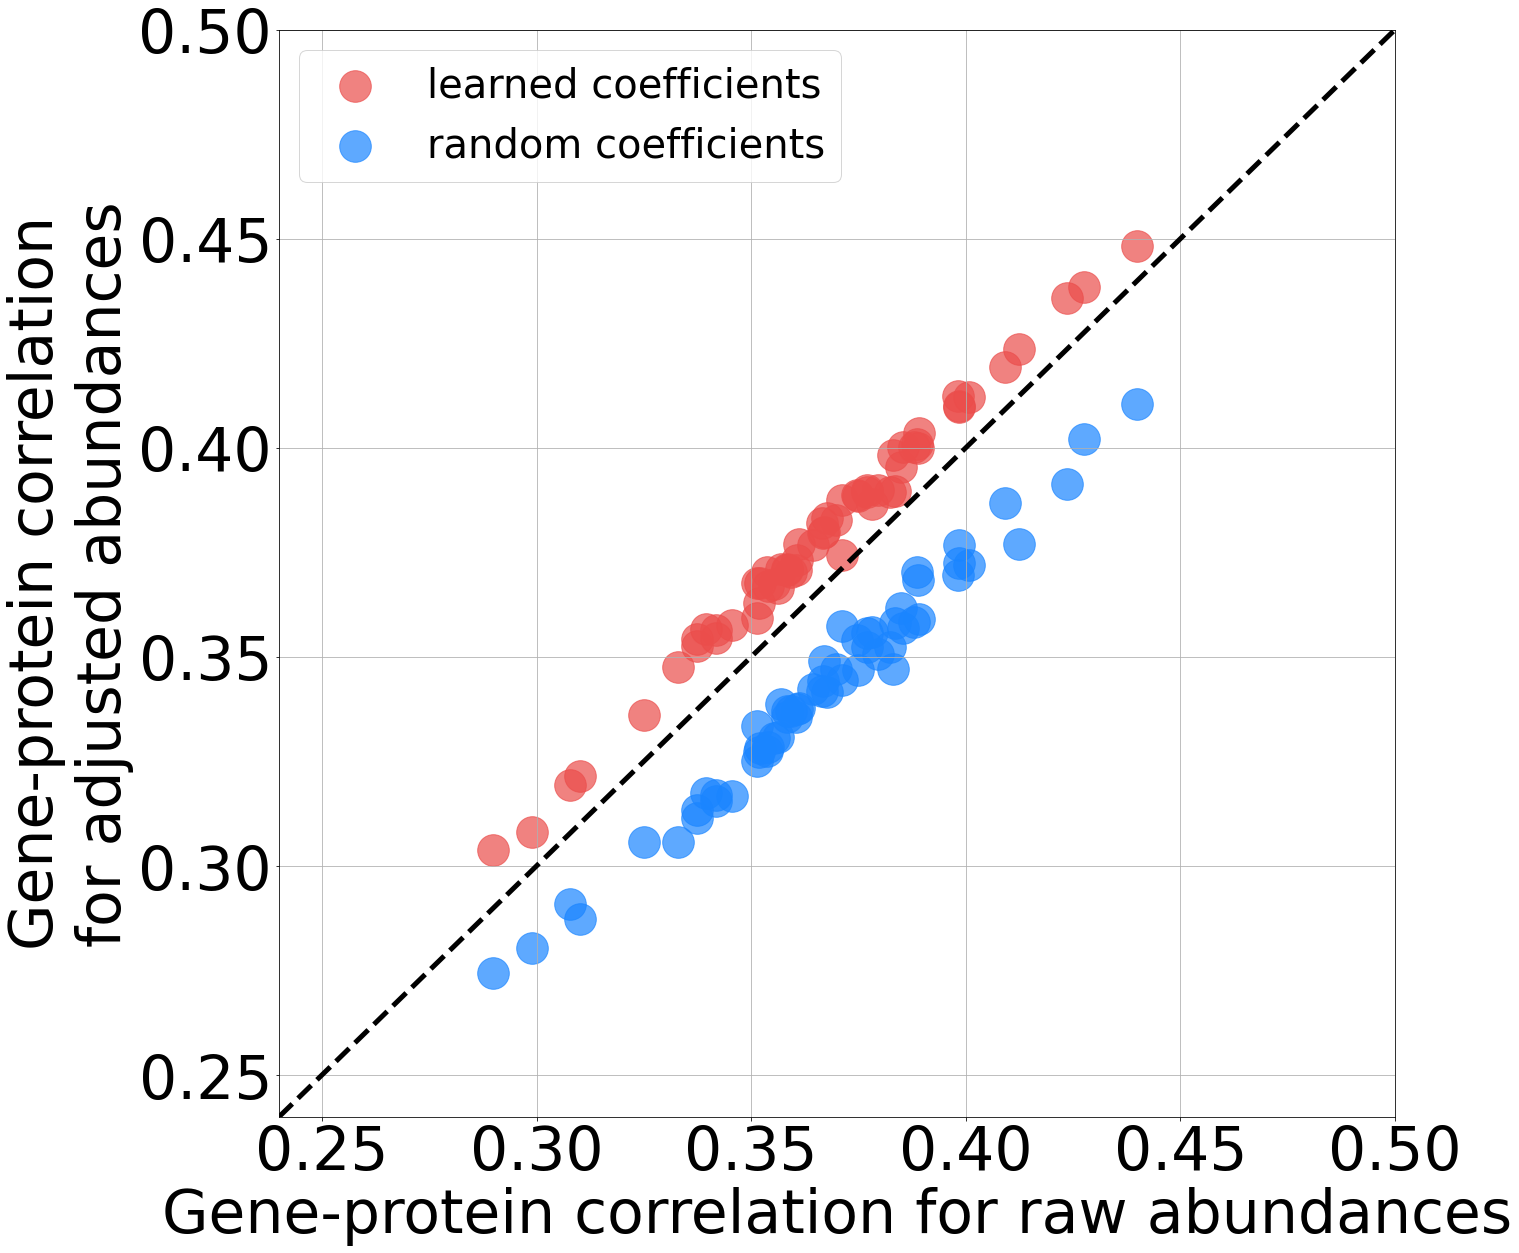

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(20, 20)

SMALL_SIZE = 40
MEDIUM_SIZE = 60
BIGGER_SIZE = 70

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.scatter(np.array(all_correlations_original[0]), 
            np.array(all_correlations_adjusted[0]),
            s = 1000, color = '#eb4d4b', alpha = 0.7, label = 'learned coefficients')

plt.scatter(np.array(all_correlations_original[0]), 
            np.array(all_correlations_random[0]),
            s = 1000, color = '#1A85FF', alpha = 0.7, label = 'random coefficients')


plt.plot([0.24, 0.5], [0.24, 0.5], '--', lw = 5, color = 'Black')
plt.xlim([0.24, 0.5])
plt.ylim([0.24, 0.5])
plt.legend()
plt.xlabel('Gene-protein correlation for raw abundances')
plt.ylabel('Gene-protein correlation \nfor adjusted abundances')
plt.grid()




In [16]:
#Read coefficients and adjust the abundances
coeff_df = pd.read_csv('../trained_models/2019_guo_nci60/2019_guo_nci60_inferred_coefficients.tsv', sep = '\t', index_col = 0)
print(coeff_df)

random_coeffs = coeff_df.values
np.random.shuffle(random_coeffs)
adjusted_abundances = peptide_df.iloc[:, 11:].values / random_coeffs
adjusted_abundances = pd.DataFrame(adjusted_abundances, 
                                   index =  peptide_df.index, 
                                   columns =  peptide_df.columns[11:])

peptide_df.iloc[:, 11:] = adjusted_abundances
peptide_df

              0
1      1.105592
3      1.936526
4      0.825157
5      0.978752
6      0.758884
...         ...
22541  0.785309
22543  0.924614
22544  0.639679
22545  1.102007
22546  0.931875

[14472 rows x 1 columns]


,Peptide,Protein,gene symbol,R2,best mscore,numNA,Charge 1,Charge 2,Charge 3,Charge 4,...,RE_CAKI1_a,RE_CAKI1_b,RE_RXF393_a,RE_RXF393_b,RE_SN12C_a,RE_SN12C_b,RE_TK10_a,RE_TK10_b,RE_UO31_a,RE_UO31_b
1,VHCCFYFISPFGHGLKPLDVAFMK,Q15019,2-Sep,0.935026,1.920000e-07,4,0,0,0,0,...,4.795762e+05,4.072989e+05,1.274267e+05,1.359763e+05,9.671430e+04,1.008515e+05,4.653133e+05,3.860404e+05,5.407296e+05,4.759927e+05
3,VNIVPVIAK,Q15019,2-Sep,0.917310,4.010000e-09,0,0,1,0,0,...,8.524898e+05,9.250951e+05,7.126379e+05,6.910780e+05,7.008421e+05,8.053171e+05,1.143629e+06,1.170116e+06,1.154784e+06,1.311295e+06
4,QQPTQFINPETPGYVGFANLPNQVHR,Q15019,2-Sep,0.897582,2.160000e-08,0,0,0,1,0,...,1.448515e+05,1.338462e+05,9.826049e+04,9.530604e+04,1.036048e+05,1.028981e+05,1.946172e+05,1.675624e+05,1.892585e+05,1.764578e+05
5,STLINSLFLTDLYPER,Q15019,2-Sep,0.893410,1.060000e-08,0,0,1,0,0,...,3.946156e+05,3.600145e+05,3.120465e+05,2.608274e+05,2.826702e+05,2.858697e+05,4.529701e+05,3.842292e+05,4.940706e+05,4.252494e+05
6,ASIPFSVVGSNQLIEAK,Q15019,2-Sep,0.882319,9.200000e-09,0,0,1,0,0,...,1.443164e+06,1.415818e+06,1.234094e+06,1.165427e+06,1.270292e+06,1.127202e+06,1.689766e+06,1.616535e+06,1.952584e+06,1.717882e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22541,CSVCSEPIMPEPGRDETVR,Q15942,ZYX,0.876235,8.910000e-07,2,0,0,1,0,...,4.530278e+05,4.138485e+05,5.557103e+05,5.405084e+05,3.276708e+05,4.094156e+05,4.028727e+05,4.228505e+05,5.079104e+05,5.143414e+05
22543,QHPVPPPAQNQNQVR,Q15942,ZYX,0.848883,7.970000e-05,14,0,1,0,0,...,1.405007e+04,1.180455e+04,2.254915e+04,2.464382e+04,1.302134e+04,1.413742e+04,1.212274e+04,1.099720e+04,2.107360e+04,2.011151e+04
22544,ALGQLFHIACFTCHQCAQQLQGQQFYSLEGAPYCEGCYTDTLEK,Q15942,ZYX,0.813338,7.390000e-08,2,0,0,0,0,...,5.714429e+04,4.728714e+04,7.260661e+04,6.019660e+04,4.220429e+04,5.556876e+04,5.672100e+04,5.274752e+04,6.226953e+04,6.800651e+04
22545,VSSGYVPPPVATPFSSK,Q15942,ZYX,0.649288,1.230000e-07,12,0,1,0,0,...,3.273821e+05,4.526874e+05,6.973714e+05,6.714910e+05,3.842423e+05,3.304935e+05,4.659102e+05,3.468117e+05,5.316829e+05,4.505712e+05


In [17]:
protein_df_adjusted = mapPeptidestoProteins(peptide_df)
all_correlations_random = calculateProteinandGeneCorrelations(protein_df_adjusted, gene_df)
all_correlations_random[0]

Mapping to protein-level using top peptide with highest R2 score
         BR_BT549_a BR_BT549_b BR_HS578T_a BR_HS578T_b BR_MCF7_a BR_MCF7_b  \
RBM47        262283     276304      393181      292002    454619    370918   
UBA6         336521     315189       47684       47684    378682    410113   
KIAA1598    79486.7     104276     13421.9     13421.9    238718    217047   
ILVBL       68413.6    69729.8     64119.3     61649.8   84353.6   86073.5   
CNOT1       65522.7    55440.2     41745.4     48220.4   75830.7   64291.7   
...             ...        ...         ...         ...       ...       ...   
DYNC1LI1    52865.6    35968.9     63437.5     61366.5   53899.3   49763.4   
IGF2BP2     7913.24    7913.24     72833.5     41509.6   36019.6   52184.5   
SLC30A1     9352.79    9352.79     9352.79     9352.79   71597.8    134318   
SLC4A7      5259.37    5259.37     5259.37     5259.37   5259.37   5259.37   
SQRDL        400061     408845      462069      236235    320179    367000   

         BRMCF7  BRMDAMB231  BRHS578T   BRBT549   BRT47D  CNSSF268  CNSSF295  \
AAAS     7.1320     5.83600   6.27000   5.94600   7.2960   6.14500    6.3620   
AAMP     9.1360     8.71800   9.19300   7.58100   8.3940   8.50300    8.4780   
AARS    11.6500     9.20500  11.73500  11.32600  12.1530  10.59200   10.6010   
AARS2    6.5015     6.47300   5.33650   5.80000   6.2555   6.02400    6.0200   
AASS     2.3750     5.41850   4.23450   2.43150   2.9500   7.18600    4.9245   
...         ...         ...       ...       ...      ...       ...       ...   
ZNF326   4.2450     4.47675   4.27475   5.06225   4.0780   4.87625    4.7050   
ZNF428   4.4540     4.12350   4.08300   4.33700   3.8180   4.33800    4.4100   
ZRANB2   8.9305     8.61700   9.62450  10.09700   9.4620   8.85050    9.5380   
ZW10     6.2180     8.01000   6.58400   7.16400   7.3650   7.44600    6.6170   
ZYX      5.5890     7.47000   8.46350   7.95150   4.9270   7.46550    8.6290   

        CNSSF539  CNSSNB19  CNSSNB75  .

[0.3504976804220879,
 0.27763775618811887,
 0.3733797883795598,
 0.336126819904267,
 0.3658491728068098,
 0.3199198565430965,
 0.3271150573965687,
 0.3250914792835419,
 0.33447290992892714,
 0.30859665462540903,
 0.3322580963085799,
 0.3619100195260115,
 0.3248096867721198,
 0.34658469365081107,
 0.35607915230070647,
 0.3314136926093559,
 0.3347228781600705,
 0.3616858675121532,
 0.3399279298916718,
 0.31022072323000466,
 0.33111779167820976,
 0.3227313706775963,
 0.28675491969195405,
 0.3690912365119187,
 0.2973130056148259,
 0.34545237973113213,
 0.36719760751549424,
 0.40355836454446237,
 0.35507996289696264,
 0.3961782706319158,
 0.3535179757202544,
 0.3817087587686931,
 0.3842763031143536,
 0.3702866821593779,
 0.3079731094773487,
 0.3458526980869054,
 0.33186111000599877,
 0.3421613244179905,
 0.3122029744076759,
 0.35342057253585035,
 0.35446498851164177,
 0.35287097002242307,
 0.3249922847341513,
 0.3459653832744916,
 0.33070992462730375,
 0.29976163727496785,
 0.30937749124669

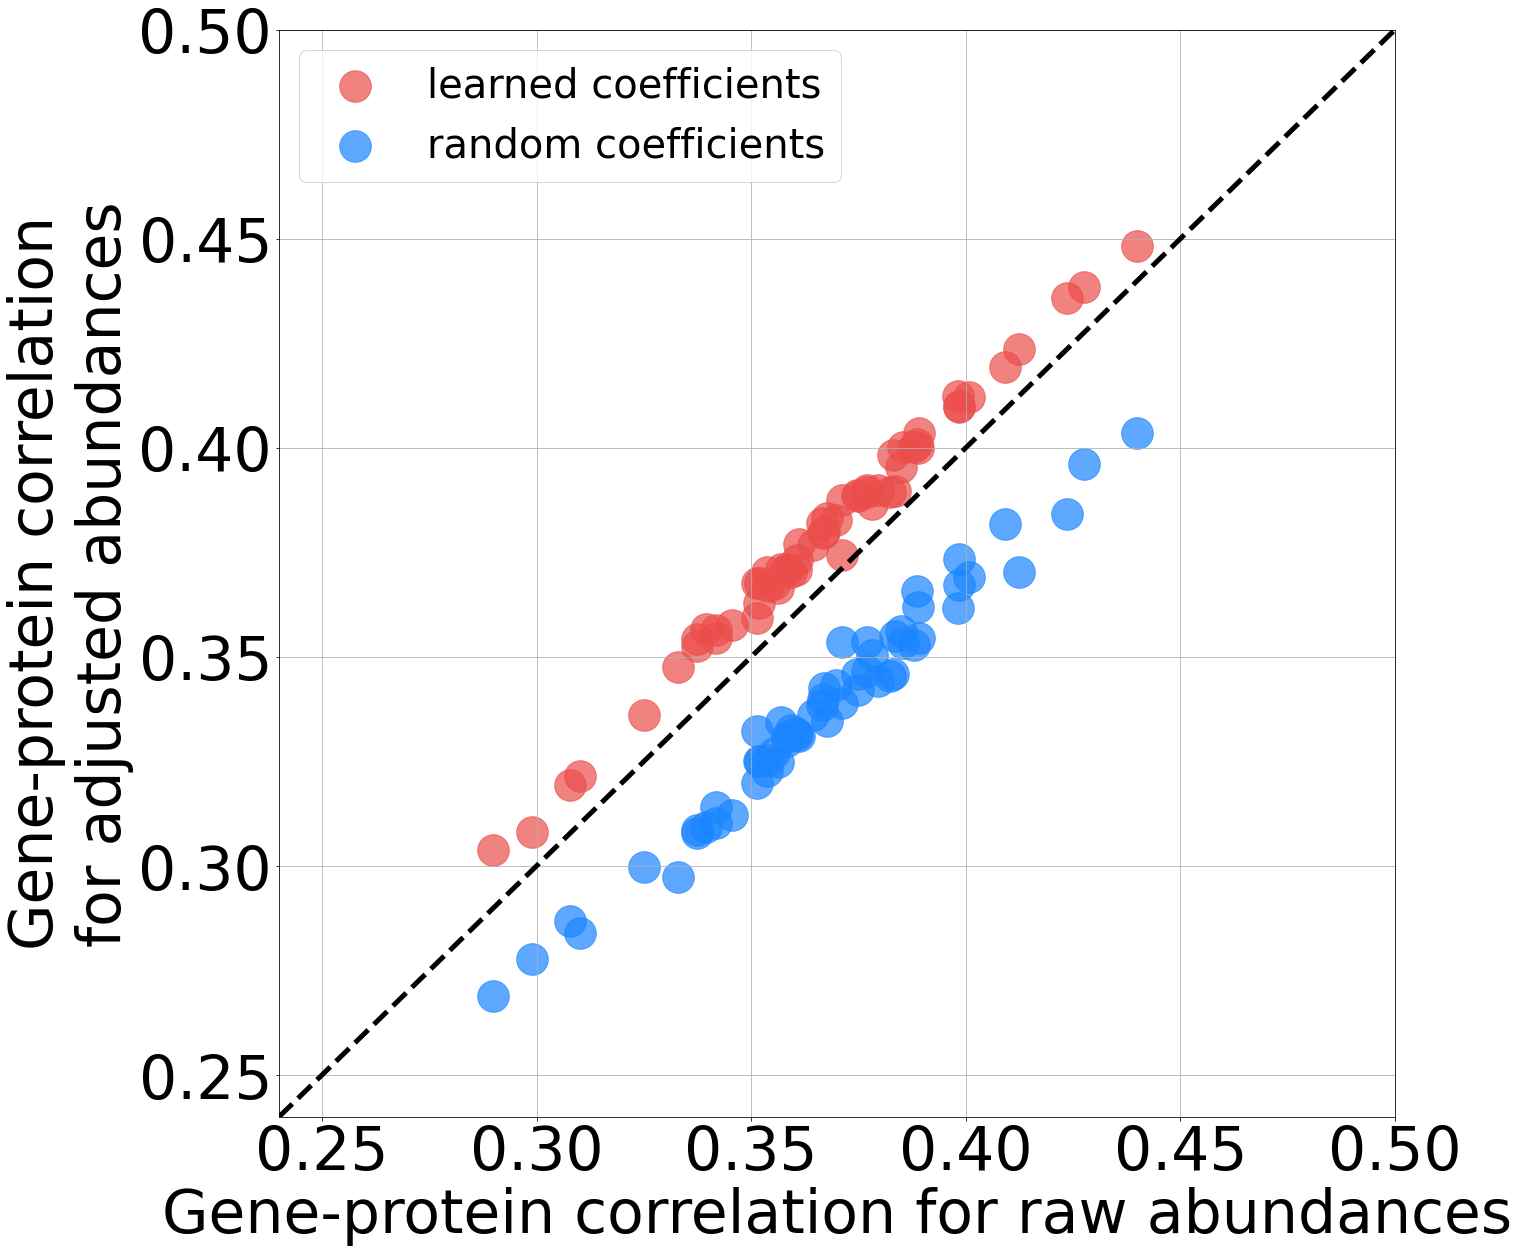

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(20, 20)

SMALL_SIZE = 40
MEDIUM_SIZE = 60
BIGGER_SIZE = 70

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.scatter(np.array(all_correlations_original[0]), 
            np.array(all_correlations_adjusted[0]),
            s = 1000, color = '#eb4d4b', alpha = 0.7, label = 'learned coefficients')

plt.scatter(np.array(all_correlations_original[0]), 
            np.array(all_correlations_random[0]),
            s = 1000, color = '#1A85FF', alpha = 0.7, label = 'random coefficients')


plt.plot([0.24, 0.5], [0.24, 0.5], '--', lw = 5, color = 'Black')
plt.xlim([0.24, 0.5])
plt.ylim([0.24, 0.5])
plt.legend()
plt.xlabel('Gene-protein correlation for raw abundances')
plt.ylabel('Gene-protein correlation \nfor adjusted abundances')
plt.grid()



